In [1]:
import os
print(os.getcwd())
os.chdir('research_files')



/mnt/c/Users/User/MSc_Project/energy_budget_PET_framework-1


In [2]:
#Libraries
import pandas as pd

import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MaxAbsScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVR
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.optimize import minimize
import sys
import io
import warnings
from datetime import datetime


data_original = pd.read_csv('energy_records.csv',  encoding='utf-8')
data = pd.read_csv('energy_records.csv',  encoding='utf-8')
data = data.drop('dataset_name', axis=1)



In [8]:
split_index = int((1 - 0.19)* len(data))
if split_index % 2 != 0:
    split_index += 1
pd.set_option('display.max_rows', 1000)
    
y_mm = data_original[['dataset_name','energy']].iloc[split_index:].reset_index(drop=False)
print(y_mm)
pd.reset_option('display.max_rows')

    index     dataset_name        energy
0     262   taiwan_16_1246    462.643418
1     263   taiwan_16_1246    488.060750
2     264   taiwan_16_2500    742.632031
3     265   taiwan_16_2500    782.809882
4     266   taiwan_16_3012    860.042763
5     267   taiwan_16_3012    901.346245
6     268   taiwan_16_4011   1088.416433
7     269   taiwan_16_4011   1126.918050
8     270    taiwan_26_743   1717.290353
9     271    taiwan_26_743   1710.053609
10    272   taiwan_26_1272   2542.819405
11    273   taiwan_26_1272   2551.645912
12    274   taiwan_26_1999   3633.134182
13    275   taiwan_26_1999   3687.172226
14    276   taiwan_26_3256   5626.517439
15    277   taiwan_26_3256   5690.916764
16    278   taiwan_26_4011   6787.285840
17    279   taiwan_26_4011   6853.205158
18    280    taiwan_30_793   3026.541283
19    281    taiwan_30_793   3049.326664
20    282   taiwan_30_1592   5189.199412
21    283   taiwan_30_1592   5217.963583
22    284   taiwan_30_2386   7290.600354
23    285   taiw

In [3]:
def count_outliers_per_record(df, features):
    outlier_counts = []  #
    df_2 = df.copy()
    df_2[features] = df_2[features].apply(pd.to_numeric, errors='coerce')
    #
    for index, row in df_2.iterrows():
        outlier_count = 0
        for feature in features:
            Q1 = df_2[feature].quantile(0.25)
            Q3 = df_2[feature].quantile(0.75)
            IQR = Q3 - Q1
            outlier_step = 1.5 * IQR
            
            
            if row[feature] < Q1 - outlier_step or row[feature] > Q3 + outlier_step:
                outlier_count += 1
        
        outlier_counts.append(outlier_count)
    
    return outlier_counts

In [3]:
features = [
    'epsilon',
    'avg_cat_uniqueness_ratio',
    'entropy',
    'imbalance_ratio',
    'kurtosis',
    'max_categorical_unique',
    'max_continuous_correlation',
    'max_std_dev',
    'max_variance',
    'mean_categorical_unique',
    'mean_continuous_correlation',
    'mean_std_dev',
    'mean_variance',
    'min_categorical_unique',
    'num_attributes',
    'num_categorical_attributes',
    'num_continuous_attributes',
    'num_records',
    'outlier_percentage',
    'size_mb',
    'skewness'
 ]

features_temp = [
    # 'epsilon',
    'avg_cat_uniqueness_ratio',
    'entropy',
    'imbalance_ratio',
    'kurtosis',
    'max_categorical_unique',
    'max_continuous_correlation',
    'max_std_dev',
    'max_variance',
    'mean_categorical_unique',
    'mean_continuous_correlation',
    'mean_std_dev',
    'mean_variance',
    'min_categorical_unique',
    'num_attributes',
    'num_categorical_attributes',
    'num_continuous_attributes',
    'num_records',
    'outlier_percentage',
    'size_mb',
    'skewness'
]
#WE are using features_temp, because we need epsilon at the top of importances, since it's a deciding factor for DP inclusion.
#Which is why for all lists, it will added on top of each list.
target_ml = 'energy'
print(len(features_temp))

20


In [ ]:
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
def comp_func(actual_values):
    result = []
    for i in range(0, len(actual_values), 2):
        # Make sure there is a pair to compare
        if i + 1 < len(actual_values):
            first = actual_values[i]
            second = actual_values[i + 1]


            if first > second:
                result.append(0)
            elif first == second:
                result.append(2)
            else:
                result.append(1)
    return result
    

def our_ml(dataset, test_size, our_features, estimators, learning_rate, depth, target, scalee):
    split_index = int((1 - test_size) * len(data))
    if split_index % 2 != 0:
        split_index += 1
    X = dataset[list(our_features)]
    y = dataset[target]
    if scalee == 1:
            continuous_ones = [i for i in our_features if i != 'epsilon']

            X_scaled = X.copy()
            X_scaled[continuous_ones] = RobustScaler().fit_transform(X[continuous_ones])

         
            X_train = X_scaled.iloc[:split_index]
            X_test = X_scaled.iloc[split_index:]
            
    else:
        X_train = X.iloc[:split_index]
        X_test = X.iloc[split_index:]
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]

    
    

    
    gb_model = GradientBoostingRegressor(n_estimators=estimators, learning_rate=learning_rate, max_depth=depth, random_state=42)
    gb_model.fit(X_train, y_train)


    y_pred = gb_model.predict(X_test)
    print('Conditions:')
    print(f'Size: {len(dataset)}')
    print(f'Test size percent is: {test_size}')
    print(f'Attributes: {our_features}')
    print('Actual')
    print(list(y_test))
    print('Prediction')
    print(y_pred)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Gradient Boosting MSE:", mse)
    print("Gradient Boosting R²:", r2)

    feature_importances = gb_model.feature_importances_


    importances = pd.Series(feature_importances, index=our_features)
    
    if len(y_pred) % 2 == 0:
        aa = []
        res_act = comp_func(y_test.reset_index(drop=True))
        res_pred = comp_func(y_pred)
        for i in range(len(res_act)):
            if res_act[i] == res_pred[i]:
                aa.append(True)
            else:
                aa.append(False)
        
        print(aa)
        
        num = aa.count(True)
        length = len(aa)
        print(f'Accuracy of the comparison which one more consumable/accurate/riskier: {(num / length) * 100} %')
        
        print('Prediction vs Actual')
        y_test_2 = list(y_test)
        ll = 0
        mm = 0
        for i in range(len(y_pred)):
            ll += 1
            print(f'{y_pred[i]}  -  {y_test_2[i]}' )
            if ll % 2 == 0:
                print(aa[mm])
                mm += 1
                print('\n')
            ...
    else:
        print('Fix the test size for even number of values.')
        y_pred = 0
        y_test_2 = 0


  
    return gb_model, y_pred, y_test_2, importances


def lightgbm_ml(our_data, our_features, target, perc, scalee, n_estimators=100, learning_rate=0.1):
    warnings.simplefilter(action='ignore', category=UserWarning)
    test_size = perc
    split_index = int((1 - test_size) * len(our_data))
    X = our_data[list(our_features)]
    y = our_data[target]

    if scalee == 1:
        continuous_ones = [i for i in our_features if i != 'epsilon']
        X_scaled = X.copy()
        X_scaled[continuous_ones] = RobustScaler().fit_transform(X[continuous_ones])
        X_train = X_scaled.iloc[:split_index]
        X_test = X_scaled.iloc[split_index:]
    else:
        X_train = X.iloc[:split_index]
        X_test = X.iloc[split_index:]

    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]


    model = lgb.LGBMRegressor(n_estimators=n_estimators, learning_rate=learning_rate, random_state=42, verbose=-1)
    
    

    model.fit(X_train, y_train)


    y_pred = model.predict(X_test)
    y_pred = np.clip(y_pred, a_min=0, a_max=None)  # Ensure no negative predictions
    

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    if len(y_pred) % 2 == 0 and len(y_test) % 2 == 0:
        aa = []
        y_test_2 = y_test.reset_index(drop=True)
        y_pred_2 = pd.Series(y_pred).reset_index(drop=True)
        res_act = comp_func(y_test_2)
        res_pred = comp_func(y_pred_2)
        
        for i in range(len(res_act)):
            if res_act[i] == res_pred[i]:
                aa.append(True)
            else:
                aa.append(False)

        num = aa.count(True)
        length = len(aa)
        acc = (num / length) * 100
    else:
        aa = []
        acc = 0

    print('\n')
    print(f'Conditions for {target}:')
    print("LightGBM Regression")
    if scalee == 1:
        print("With Scaler")
    print(f'Number of Estimators: {n_estimators}')
    print(f'Learning Rate: {learning_rate}')
    print(f"Best MSE: {mse:.10f}")
    print(f"Best R²: {r2:.10f}")
    print(f'Test size: {perc}')
    print(f"Best Feature Combination: {our_features}")

    print(f'Accuracy: {acc}%')
    
    print("Feature Importances:")
    single_importances_series = pd.Series(model.feature_importances_ , index=our_features)
    importances_percentages = (single_importances_series / single_importances_series.sum())
    print(importances_percentages)
    
    
    # importances_sorted = single_importances_series.sort_values(ascending=False)
    return model, y_pred.tolist(), y_test.tolist(), importances_percentages




Brute Force

In [6]:

brute_force_features_1 = ['epsilon', 'num_attributes', 'avg_cat_uniqueness_ratio',  'entropy', 'mean_categorical_unique', 'num_records', 'max_std_dev', 
                          'mean_continuous_correlation', 'kurtosis', 'num_continuous_attributes', 'max_variance', 'mean_variance']
brute_force_1, brute_force_predictions, brute_force_actual, brute_force_importances  = our_ml(data, 0.19, brute_force_features_1 , 100, 0.1, 3, target_ml, 0)
print(brute_force_importances.sort_values(ascending=False))
"""  

"""


Conditions:
Size: 324
Test size percent is: 0.19
Attributes: ['epsilon', 'num_attributes', 'avg_cat_uniqueness_ratio', 'entropy', 'mean_categorical_unique', 'num_records', 'max_std_dev', 'mean_continuous_correlation', 'kurtosis', 'num_continuous_attributes', 'max_variance', 'mean_variance']
Actual
[462.643418, 488.06075, 742.632031, 782.809882, 860.042763, 901.346245, 1088.416433, 1126.91805, 1717.290353, 1710.053609, 2542.819405, 2551.645912, 3633.134182, 3687.172226, 5626.517439, 5690.916764, 6787.28584, 6853.205158, 3026.541283, 3049.326664, 5189.199412, 5217.963583, 7290.600354, 7366.503781, 9787.731456, 9815.414741, 334.233642, 321.160607, 576.596885, 567.214567, 771.837764, 734.011365, 913.251828, 886.981047, 890.05102, 885.00182, 1615.613249, 1650.325474, 2221.604461, 2248.092942, 2671.377854, 2698.24409, 1980.37752, 1931.5505, 3739.515157, 3709.78575, 5217.010637, 5200.976649, 6280.731049, 6238.258525, 7515.246971, 7520.636069, 10553.21626, 10548.05901, 12762.85089, 12768.03834

'  \n\n'

# Now, Let's take a look at if the feature analyses will demonstrate better results.

## Sequential Feature Selection

In [ ]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import lightgbm as lgb

import numpy as np

def comp_func(actual_values):
    result = []
    for i in range(0, len(actual_values), 2):
        # Make sure there is a pair to compare
        if i + 1 < len(actual_values):
            first = actual_values[i]
            second = actual_values[i + 1]


            if first > second:
                result.append(0)
            else:
                result.append(1)
    return result

def our_sfs_ml(dataset, test_size, our_features, estimators, learning_rate, depth, n_features, scalee, direction_s = 'forward'):
    
    split_index = int((1 - test_size) * len(dataset))
    X = dataset[list(our_features)] 
    y = dataset[target_ml]

    if scalee == 1:
        continuous_ones = [i for i in our_features if i != 'epsilon']
        X_scaled = X.copy()
        X_scaled[continuous_ones] = RobustScaler().fit_transform(X[continuous_ones])
        X_train = X_scaled.iloc[:split_index]
        X_test = X_scaled.iloc[split_index:]
    else:
        X_train = X.iloc[:split_index]
        X_test = X.iloc[split_index:]
        
    y_train = y.iloc[:split_index]
    y_test = y.iloc[split_index:]

    
    # gb_model = GradientBoostingRegressor(n_estimators=estimators, learning_rate=learning_rate, max_depth=depth, random_state=42)
    gb_model = GradientBoostingRegressor(n_estimators=estimators, learning_rate=learning_rate, max_depth=depth, random_state=42)
    
    # Perform Sequential Feature Selection
    sfs = SequentialFeatureSelector(gb_model, n_features_to_select=n_features, direction=direction_s, scoring='r2', n_jobs=-1)
    sfs.fit(X_train, y_train)
    
    selected_features = list(X_train.columns[sfs.get_support()])
    
    if 'epsilon' not in selected_features:
        return sfs, selected_features, -100, -100, None, 0

    # Refit the model using only the selected features
    gb_model.fit(X_train[selected_features], y_train)

    # Make predictions on the test set using the refitted model
    y_pred = gb_model.predict(X_test[selected_features])
    y_pred = np.clip(y_pred, a_min=0, a_max=None)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Collect feature importances from the refitted model
    feature_importances = gb_model.feature_importances_

    # Create a DataFrame with feature names and their importances
    selected_features_df = pd.DataFrame({
        'Feature': selected_features,
        'Importance': feature_importances
    })

    # Normalize importances to get percentages
    selected_features_df['Importance_Percentage'] = 100 * (selected_features_df['Importance'] / selected_features_df['Importance'].sum())
    

    selected_features_df = selected_features_df.sort_values(by='Importance_Percentage', ascending=False)

    if len(y_pred) % 2 == 0:
        aa = []
        res_act = comp_func(y_test.reset_index(drop=True))
        res_pred = comp_func(y_pred)
        for i in range(len(res_act)):
            if res_act[i] == res_pred[i]:
                aa.append(True)
            else:
                aa.append(False)

        num = aa.count(True)
        length = len(aa)
        acc = (num / length) * 100
        if acc > 80 and r2 > 0.8:
            print(f'Accuracy of the comparison which one more consumable/accurate/riskier: {acc}%')
            print(f'R2: {r2}')
            print(f'MSE: {mse}')
            print(f'Selected features: {selected_features}')
            print(f'Number of estimators: {estimators}')
            print(f'Learning rate: {learning_rate}')

    return gb_model, selected_features, r2, mse, selected_features_df, acc



Conditions:
Size: 324
Test size percent is: 0.19
Attributes: ['epsilon', 'avg_cat_uniqueness_ratio', 'entropy', 'imbalance_ratio', 'kurtosis', 'max_categorical_unique', 'max_continuous_correlation', 'max_std_dev', 'max_variance', 'mean_categorical_unique', 'mean_continuous_correlation', 'mean_std_dev', 'mean_variance', 'min_categorical_unique', 'num_attributes', 'num_categorical_attributes', 'num_continuous_attributes', 'num_records', 'outlier_percentage', 'size_mb', 'skewness']
Actual
[462.643418, 488.06075, 742.632031, 782.809882, 860.042763, 901.346245, 1088.416433, 1126.91805, 1717.290353, 1710.053609, 2542.819405, 2551.645912, 3633.134182, 3687.172226, 5626.517439, 5690.916764, 6787.28584, 6853.205158, 3026.541283, 3049.326664, 5189.199412, 5217.963583, 7290.600354, 7366.503781, 9787.731456, 9815.414741, 334.233642, 321.160607, 576.596885, 567.214567, 771.837764, 734.011365, 913.251828, 886.981047, 890.05102, 885.00182, 1615.613249, 1650.325474, 2221.604461, 2248.092942, 2671.3778

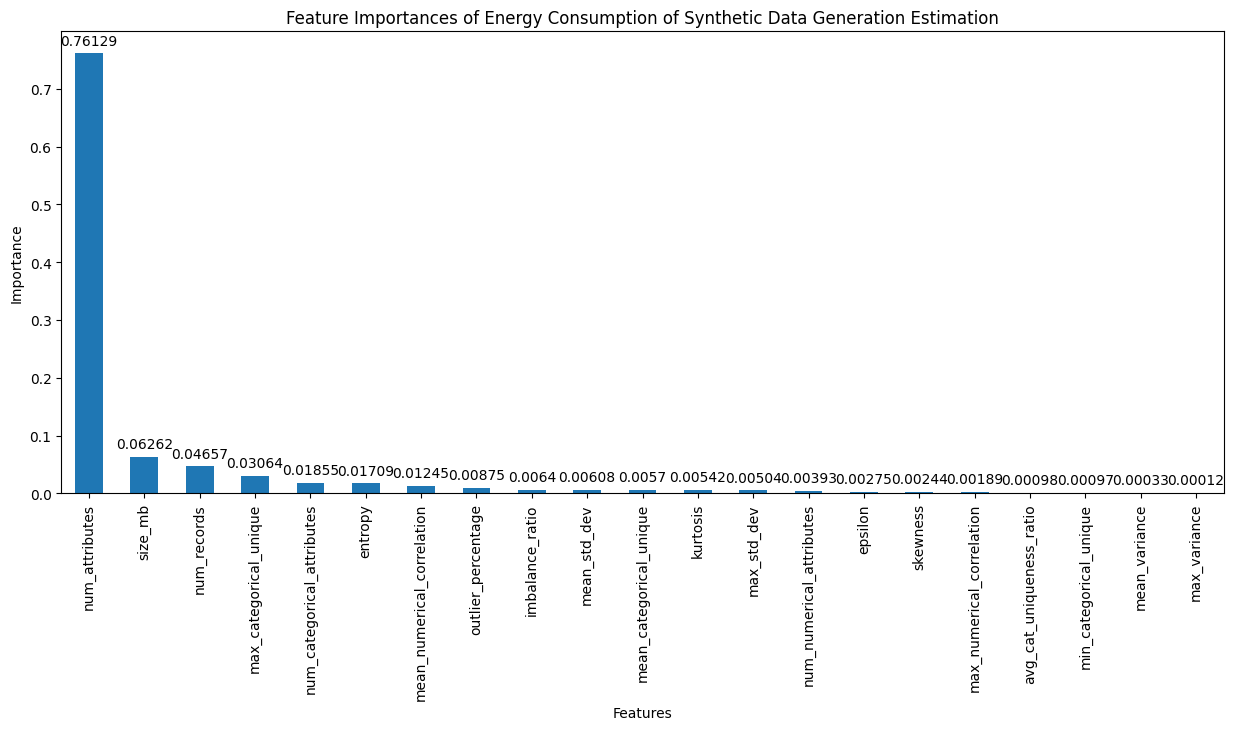

' \nGradient Boosting MSE: 5838055.293199735\nGradient Boosting R²: 0.4337760066501035\nAccuracy of the comparison which one more consumable/accurate/riskier: 77.41935483870968 %\n\n'

In [ ]:

a, aa, aaa, all_importances_regular  = our_ml(data, 0.19, features, 100, 0.1, 3, target_ml, 0)
# print(all_importances_regular)
# importances_sorted = best_importances.sort_values(ascending=False)
importances_sorted = all_importances_regular.sort_values(ascending=False)
importances_sorted_no_epsilon = importances_sorted.drop('epsilon')
print(importances_sorted_no_epsilon)
importances_sorted_no_epsilon_list = importances_sorted_no_epsilon.index.to_list()
lists_ttt = [importances_sorted_no_epsilon[:(i)].index.to_list() for i in range(4, 21)]
lists_ttt = [ ['epsilon'] + i
             for i in lists_ttt
]
print(len(lists_ttt[-1]))
# pd.options.display.float_format = '{:.4f}'.format
importances_sorted = importances_sorted.round(5)
print(importances_sorted)
# Plot the feature importances
plt.figure(figsize=(15, 6))
ax = importances_sorted.plot(kind='bar')
for i, v in enumerate(importances_sorted.values):
    ax.text(i, v + 0.01, f'{v}', ha='center', va='bottom')
plt.title('Feature Importances of Energy Consumption of Synthetic Data Generation Estimation')
plt.xlabel('Features')
plt.ylabel('Importance')
# plt.savefig('energy_importances.png')
plt.show()
""" 
Gradient Boosting MSE: 5838055.293199735
Gradient Boosting R²: 0.4337760066501035
Accuracy of the comparison which one more consumable/accurate/riskier: 77.41935483870968 %

"""

In [9]:
print(lists_ttt)

[['epsilon', 'num_attributes', 'size_mb', 'num_records', 'max_categorical_unique'], ['epsilon', 'num_attributes', 'size_mb', 'num_records', 'max_categorical_unique', 'num_categorical_attributes'], ['epsilon', 'num_attributes', 'size_mb', 'num_records', 'max_categorical_unique', 'num_categorical_attributes', 'entropy'], ['epsilon', 'num_attributes', 'size_mb', 'num_records', 'max_categorical_unique', 'num_categorical_attributes', 'entropy', 'mean_continuous_correlation'], ['epsilon', 'num_attributes', 'size_mb', 'num_records', 'max_categorical_unique', 'num_categorical_attributes', 'entropy', 'mean_continuous_correlation', 'outlier_percentage'], ['epsilon', 'num_attributes', 'size_mb', 'num_records', 'max_categorical_unique', 'num_categorical_attributes', 'entropy', 'mean_continuous_correlation', 'outlier_percentage', 'imbalance_ratio'], ['epsilon', 'num_attributes', 'size_mb', 'num_records', 'max_categorical_unique', 'num_categorical_attributes', 'entropy', 'mean_continuous_correlation

In [10]:
start_time_total = datetime.now()

ests = [100]
existing_r2s_1 = set()
for l in lists_ttt:
    start_time = datetime.now()
    for i in range(4, len(l)):
        print(f'\r{i - 3} out of {len(l) - 4 }', end='\r',  flush=True)
        for es in ests:
            
            sfs_params, sfs_features, o_r2, o_mse, selected_features_df, o_acc = our_sfs_ml(
                        dataset=data, test_size=0.19, our_features=l, 
                        estimators=es, learning_rate=0.1, depth=3, n_features=i, scalee=0, direction_s='forward'
                    )
            if o_r2 in existing_r2s_1:
                continue
            if o_r2 > 0.8 and o_acc > 70:
                existing_r2s_1.add(o_r2)
                print(f'Learning rate: 0.1')
                print(f'Estimators: {es}')
                print(f'Input Features: {l}')
                print(f'Number of Features to choose {i}')
                print(sfs_features)
                print(f'R2: {o_r2}')
                print( f'MSE: {o_mse}')
                print(  selected_features_df)
                print(f'Comparison Accuracy: {o_acc}')
                print('\n')


    end_time = datetime.now()

    elapsed_time = (end_time - start_time).total_seconds() / 60

    print(f"Elapsed time: {elapsed_time:.2f} minutes with list size {len(l)}")
end_time_total = datetime.now()

elapsed_time_total = (end_time_total - start_time_total).total_seconds() / 60

print(f"Total lapsed time: {elapsed_time_total:.2f} minutes")

"""
Learning rate: 0.1
Estimators: 100
Input Features: ['epsilon', 'num_attributes', 'size_mb', 'num_records', 'max_categorical_unique', 'num_categorical_attributes', 'entropy', 'mean_continuous_correlation', 'outlier_percentage', 'imbalance_ratio', 'mean_std_dev']
Number of Features to choose 5
['epsilon', 'num_attributes', 'num_records', 'max_categorical_unique', 'mean_std_dev']
R2: 0.8571450512154247
MSE: 1472906.6583305341
                  Feature  Importance  Importance_Percentage
1          num_attributes       0.804                 80.440
2             num_records       0.096                  9.579
3  max_categorical_unique       0.050                  4.966
4            mean_std_dev       0.047                  4.682
0                 epsilon       0.003                  0.332
Comparison Accuracy: 77.41935483870968


"""

Learning rate: 0.1
Estimators: 100
Input Features: ['epsilon', 'num_attributes', 'size_mb', 'num_records', 'max_categorical_unique']
Number of Features to choose 4
['epsilon', 'num_attributes', 'num_records', 'max_categorical_unique']
R2: 0.8054300986542466
MSE: 2006113.933336967
                  Feature  Importance  Importance_Percentage
1          num_attributes    0.831470              83.146973
2             num_records    0.107584              10.758394
3  max_categorical_unique    0.058037               5.803747
0                 epsilon    0.002909               0.290887
Comparison Accuracy: 77.41935483870968


Elapsed time: 0.22 minutes with list size 5
Elapsed time: 0.15 minutes with list size 6
Elapsed time: 0.27 minutes with list size 7
Elapsed time: 0.67 minutes with list size 8
Elapsed time: 1.03 minutes with list size 9
Elapsed time: 1.44 minutes with list size 10
Learning rate: 0.1
Estimators: 100
Input Features: ['epsilon', 'num_attributes', 'size_mb', 'num_records', '

"\nLearning rate: 0.1\nEstimators: 100\nInput Features: ['epsilon', 'num_attributes', 'size_mb', 'num_records', 'max_categorical_unique', 'num_categorical_attributes', 'entropy', 'mean_continuous_correlation', 'outlier_percentage', 'imbalance_ratio', 'mean_std_dev']\nNumber of Features to choose 5\n['epsilon', 'num_attributes', 'num_records', 'max_categorical_unique', 'mean_std_dev']\nR2: 0.8571450512154247\nMSE: 1472906.6583305341\n                  Feature  Importance  Importance_Percentage\n1          num_attributes       0.804                 80.440\n2             num_records       0.096                  9.579\n3  max_categorical_unique       0.050                  4.966\n4            mean_std_dev       0.047                  4.682\n0                 epsilon       0.003                  0.332\nComparison Accuracy: 77.41935483870968\n\n\n"

In [11]:
start_time_total = datetime.now()

ests = [100]
# existing_r2s_2 = set()
for l in lists_ttt:
    start_time = datetime.now()
    for i in range(4, len(l)):
        print(f'\r{i - 3} out of {len(l) - 4 }', end='\r',  flush=True)
        for es in ests:
            
            sfs_params, sfs_features, o_r2, o_mse, selected_features_df, o_acc = our_sfs_ml(
                        dataset=data, test_size=0.19, our_features=l, 
                        estimators=es, learning_rate=0.1, depth=3, n_features=i, scalee=0, direction_s='backward'
                    )
            if o_r2 in existing_r2s_1:
                continue
            if o_r2 > 0.8 and o_acc > 70:
                existing_r2s_1.add(o_r2)
                print(f'Learning rate: 0.1')
                print(f'Estimators: {es}')
                print(f'Input Features: {l}')
                print(f'Number of Features to choose {i}')
                print(sfs_features)
                print(f'R2: {o_r2}')
                print( f'MSE: {o_mse}')
                print(  selected_features_df)
                print(f'Comparison Accuracy: {o_acc}')
                print('\n')


    end_time = datetime.now()

    elapsed_time = (end_time - start_time).total_seconds() / 60

    print(f"Elapsed time: {elapsed_time:.2f} minutes with list size {len(l)}")
end_time_total = datetime.now()

elapsed_time_total = (end_time_total - start_time_total).total_seconds() / 60

print(f"Total lapsed time: {elapsed_time_total:.2f} minutes")

"""  

"""

Elapsed time: 0.01 minutes with list size 5
Elapsed time: 0.04 minutes with list size 6
Elapsed time: 0.09 minutes with list size 7
Elapsed time: 0.16 minutes with list size 8
Elapsed time: 0.26 minutes with list size 9
Elapsed time: 0.42 minutes with list size 10
Elapsed time: 0.64 minutes with list size 11
Elapsed time: 0.91 minutes with list size 12
Elapsed time: 1.22 minutes with list size 13
Elapsed time: 1.67 minutes with list size 14
Elapsed time: 2.16 minutes with list size 15
Accuracy of the comparison which one more consumable/accurate/riskier: 80.64516129032258%
R2: 0.8114576696696387
MSE: 1943966.6324722338
Selected features: ['epsilon', 'num_attributes', 'num_records', 'max_categorical_unique', 'entropy', 'mean_std_dev', 'kurtosis', 'skewness']
Number of estimators: 100
Learning rate: 0.1
Learning rate: 0.1
Estimators: 100
Input Features: ['epsilon', 'num_attributes', 'size_mb', 'num_records', 'max_categorical_unique', 'num_categorical_attributes', 'entropy', 'mean_continu

'  \n\n'

Best result, manually taken from the executions.

In [7]:
best_features_1 = ['epsilon', 'num_attributes', 'num_records', 'max_categorical_unique', 'mean_std_dev']
"""
Gradient Boosting MSE: 1472906.6583305341
Gradient Boosting R²: 0.8571450512154247
[False, True, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, False, False, True, True, True, True, True, False, True, True, False, True]
Accuracy of the comparison which one more consumable/accurate/riskier: 77.41935483870968 %
"""


best_model, best_predictions, best_actual, best_importances = our_ml(data, 0.19, best_features_1 , 100, 0.1, 3, target_ml, 0)

Conditions:
Size: 324
Test size percent is: 0.19
Attributes: ['epsilon', 'num_attributes', 'num_records', 'max_categorical_unique', 'mean_std_dev']
Actual
[462.643418, 488.06075, 742.632031, 782.809882, 860.042763, 901.346245, 1088.416433, 1126.91805, 1717.290353, 1710.053609, 2542.819405, 2551.645912, 3633.134182, 3687.172226, 5626.517439, 5690.916764, 6787.28584, 6853.205158, 3026.541283, 3049.326664, 5189.199412, 5217.963583, 7290.600354, 7366.503781, 9787.731456, 9815.414741, 334.233642, 321.160607, 576.596885, 567.214567, 771.837764, 734.011365, 913.251828, 886.981047, 890.05102, 885.00182, 1615.613249, 1650.325474, 2221.604461, 2248.092942, 2671.377854, 2698.24409, 1980.37752, 1931.5505, 3739.515157, 3709.78575, 5217.010637, 5200.976649, 6280.731049, 6238.258525, 7515.246971, 7520.636069, 10553.21626, 10548.05901, 12762.85089, 12768.03834, 2551.18912, 1671.805631, 5394.574331, 5451.237669, 3575.644242, 3429.371356]
Prediction
[  768.70697101   453.33164764   953.66824687  1578.98

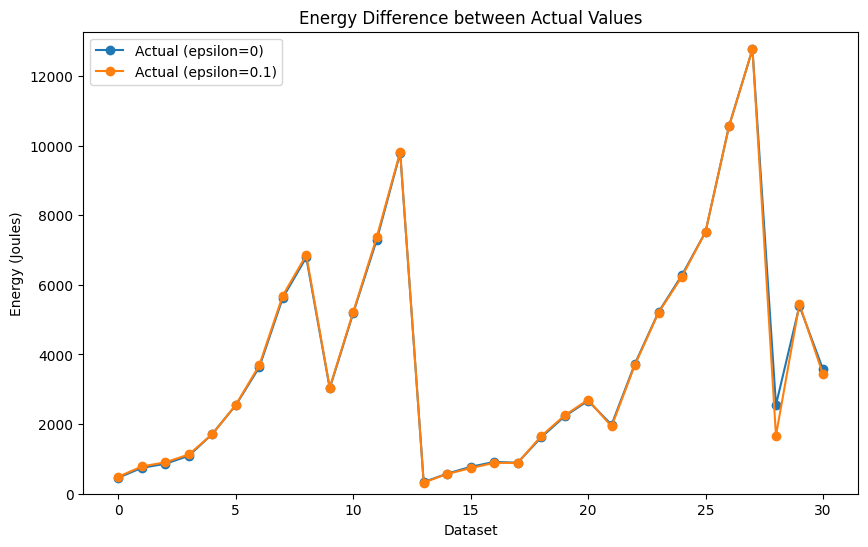

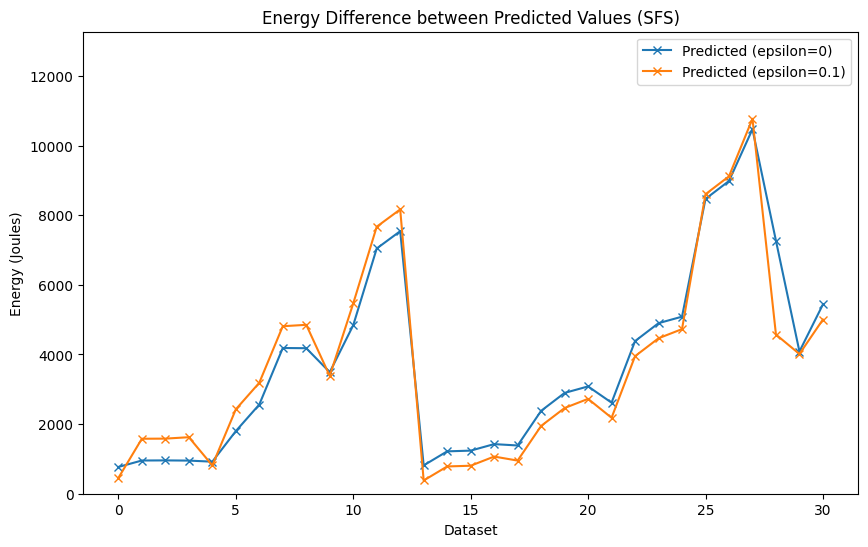

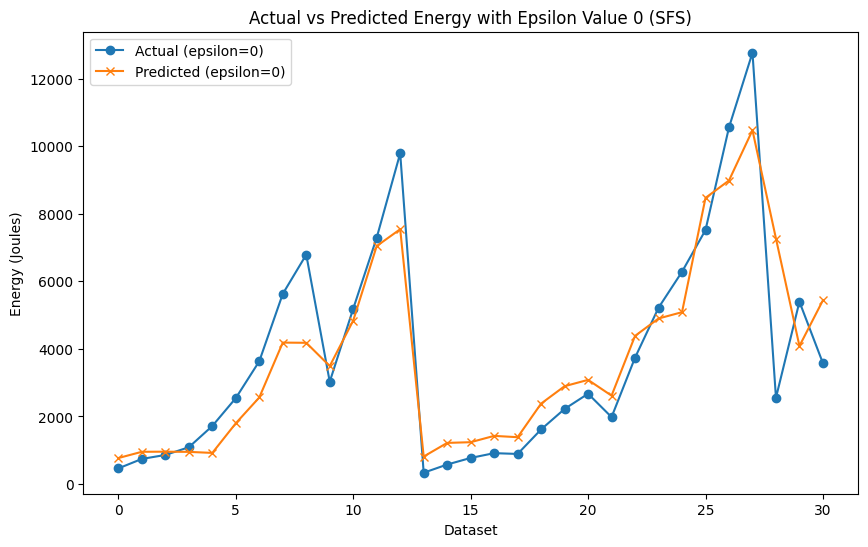

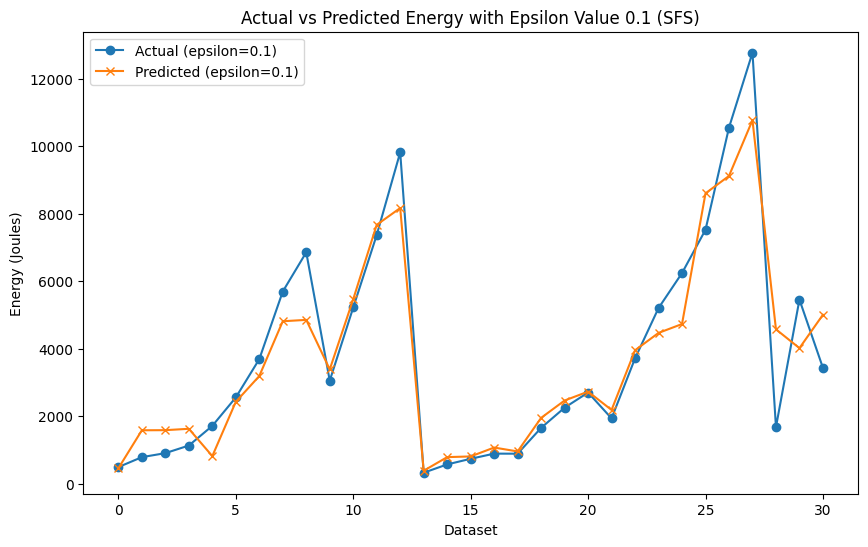

In [ ]:
import matplotlib.pyplot as plt

# Separate the data by epsilon
best_actual_0 = [best_actual[i] for i in range(0, len(best_actual), 2)]   # Actual values for epsilon 0
best_actual_01 = [best_actual[i] for i in range(1, len(best_actual), 2)]  # Actual values for epsilon 0.1
y_pred_0 = [best_predictions[i] for i in range(0, len(best_predictions), 2)]  # Predicted values for epsilon 0
y_pred_01 = [best_predictions[i] for i in range(1, len(best_predictions), 2)] # Predicted values for epsilon 0.1


x_indices_0 = range(len(best_actual_0))     # Indices for epsilon 0
x_indices_01 = range(len(best_actual_01))   # Indices for epsilon 0.1
y_min = 0
y_max = max(max(best_actual_0), max(best_actual_01), max(y_pred_0), max(y_pred_01)) + 500
# Plot 1: Difference between actual values
plt.figure(figsize=(10, 6))
plt.plot(x_indices_0, best_actual_0, label='Actual (epsilon=0)', marker='o')
plt.plot(x_indices_01, best_actual_01, label='Actual (epsilon=0.1)', marker='o')
plt.ylim(y_min, y_max)
plt.title('Energy Difference between Actual Values')
plt.xlabel('Dataset')
plt.ylabel('Energy (Joules)')
plt.legend()
# plt.savefig('energy_difference_between_actual_values.png')  
plt.show()

# Plot 2: Difference between predicted values
plt.figure(figsize=(10, 6))
plt.plot(x_indices_0, y_pred_0, label='Predicted (epsilon=0)', marker='x')
plt.plot(x_indices_01, y_pred_01, label='Predicted (epsilon=0.1)', marker='x')
plt.ylim(y_min, y_max)
plt.title('Energy Difference between Predicted Values (SFS)')
plt.xlabel('Dataset')
plt.ylabel('Energy (Joules)')
plt.legend()
plt.savefig('energy_difference_between_predicted_values.png')  
plt.show()

# Plot 3: Actual vs Predicted for epsilon 0
plt.figure(figsize=(10, 6))
plt.plot(x_indices_0, best_actual_0, label='Actual (epsilon=0)', marker='o')
plt.plot(x_indices_0, y_pred_0, label='Predicted (epsilon=0)', marker='x')
plt.title('Actual vs Predicted Energy with Epsilon Value 0 (SFS)')
plt.xlabel('Dataset')
plt.ylabel('Energy (Joules)')
plt.legend()
plt.savefig('energy_actual_vs_predicted_epsilon_0.png')  
plt.show()

# Plot 4: Actual vs Predicted for epsilon 0.1
plt.figure(figsize=(10, 6))
plt.plot(x_indices_01, best_actual_01, label='Actual (epsilon=0.1)', marker='o')
plt.plot(x_indices_01, y_pred_01, label='Predicted (epsilon=0.1)', marker='x')
plt.title('Actual vs Predicted Energy with Epsilon Value 0.1 (SFS)')
plt.xlabel('Dataset')
plt.ylabel('Energy (Joules)')
plt.legend()
plt.savefig('energy_actual_vs_predicted_epsilon_01.png')  
plt.show()


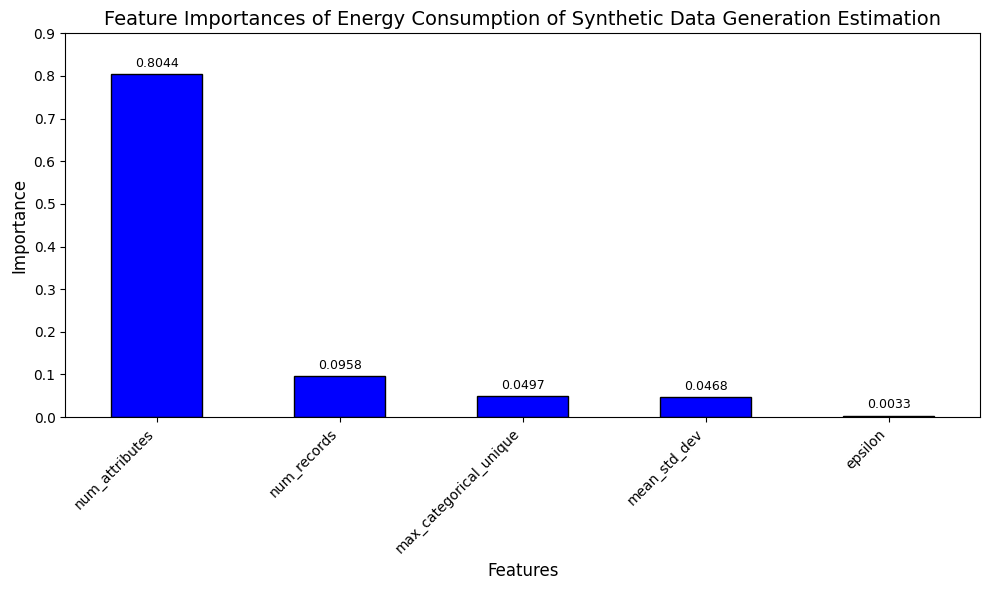

In [ ]:
importances_sorted = best_importances.sort_values(ascending=False)

# Set display options for rounded float format
pd.options.display.float_format = '{:.3f}'.format  # Set to 3 decimal places

# Plot the feature importances
plt.figure(figsize=(10, 6))
ax = importances_sorted.plot(kind='bar', color='blue', edgecolor='black')

# Add rounded values above bars
for i, v in enumerate(importances_sorted.values):
    ax.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom', fontsize=9)  # Rounded to 3 decimals

# Improve axis labels and title
plt.title('Feature Importances of Energy Consumption of Synthetic Data Generation Estimation', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Importance', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate feature names for better readability
plt.tight_layout()  # Adjust layout to fit all elements
plt.ylim(0, 0.9)

plt.savefig('energy_importances.png')
plt.show()


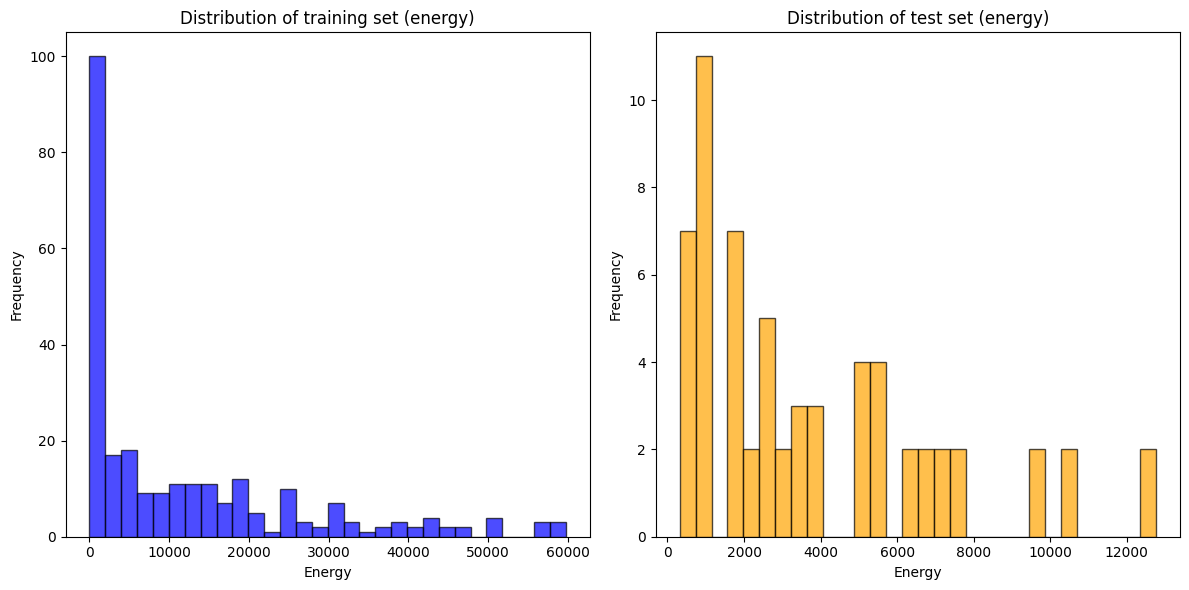

In [ ]:
split_index = int((1 - 0.19)* len(data))
if split_index % 2 != 0:
    split_index += 1
y = data[target_ml]
y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]

plt.figure(figsize=(12, 6))

# Histogram for y_train
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of training set (energy)')
plt.xlabel('Energy')
plt.ylabel('Frequency')

# Histogram for y_test
plt.subplot(1, 2, 2)
plt.hist(y_test, bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.title('Distribution of test set (energy)')
plt.xlabel('Energy')
plt.ylabel('Frequency')



plt.tight_layout()
plt.savefig('energy_distribution.png')
plt.show()